# The Movies Database (TMDb) - Movie Recommendations and Predicted Ratings

by The Monty Pythons: Mrugank Dave - Bridget Donkor - Sam Elalouf - Dennis Lee - Adista Nursani

    ~ How can we recommend a movie to users, and can we predict the rating of a movie? ~
    
Streaming services such as Netflix and YouTube have become all the rage while everyone is at home during the pandemic. To keep us entertained, these streaming services need to be able to recommend the movies users prefer. Today, we will be decibing a movie recommendation system that can be used to recommend similar movies and predict the rating of a given movie

The dataset consists of two .csv files (tmdb_5000_credits.csv and tmdb_5000_movies.csv). We will combine the data into one data frame which we will use to discover facts and finally make a reccomendation system.




Import packages and datasets:

In [12]:
import pandas as pd
import numpy as np
import math
import re
import json
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
movies = pd.read_csv('C:/Users/Bridget/Desktop/anaconda files/Project files/tmdb_5000_movies.csv')
credits = pd.read_csv('C:/Users/Bridget/Desktop/anaconda files/Project files//tmdb_5000_credits.csv')

Take a glimpse of the data - several columns are in the JSON format.

In [14]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [15]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


We will transform columns with the JSON formats into string then put them into lists.
JSON format is similar to a dictionary format, containing 'keys' and 'values'.

In [16]:
# changing the genres column from json to string
movies['genres'] = movies['genres'].apply(json.loads)
for index,i in zip(movies.index,movies['genres']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) # the key 'name' contains the name of the genre
    movies.loc[index,'genres'] = str(list1)

In [17]:
# changing the keywords column from json to string
movies['keywords'] = movies['keywords'].apply(json.loads)
for index,i in zip(movies.index,movies['keywords']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'keywords'] = str(list1)

In [18]:
# changing the production_companies column from json to string
movies['production_companies'] = movies['production_companies'].apply(json.loads)
for index,i in zip(movies.index,movies['production_companies']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'production_companies'] = str(list1)

In [19]:
# changing the production_countries column from json to string
movies['production_countries'] = movies['production_countries'].apply(json.loads)
for index,i in zip(movies.index,movies['production_countries']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'production_countries'] = str(list1)

In [20]:
# changing the spoken_languages column from json to string
movies['spoken_languages'] = movies['spoken_languages'].apply(json.loads)
for index,i in zip(movies.index,movies['spoken_languages']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) 
    movies.loc[index,'spoken_languages'] = str(list1)

In [21]:
# changing the cast column from json to string
credits['cast'] = credits['cast'].apply(json.loads)
for index,i in zip(credits.index,credits['cast']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    credits.loc[index,'cast'] = str(list1)

In [22]:
# changing the crew column from json to string
credits['crew'] = credits['crew'].apply(json.loads)
for index,i in zip(credits.index,credits['crew']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    credits.loc[index,'crew'] = str(list1)

In [23]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",http://www.avatarmovie.com/,19995,"['culture clash', 'future', 'space war', 'spac...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"['Ingenious Film Partners', 'Twentieth Century...","['United States of America', 'United Kingdom']",2009-12-10,2787965087,162.0,"['English', 'Español']",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"['Adventure', 'Fantasy', 'Action']",http://disney.go.com/disneypictures/pirates/,285,"['ocean', 'drug abuse', 'exotic island', 'east...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"['Walt Disney Pictures', 'Jerry Bruckheimer Fi...",['United States of America'],2007-05-19,961000000,169.0,['English'],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"['Action', 'Adventure', 'Crime']",http://www.sonypictures.com/movies/spectre/,206647,"['spy', 'based on novel', 'secret agent', 'seq...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"['Columbia Pictures', 'Danjaq', 'B24']","['United Kingdom', 'United States of America']",2015-10-26,880674609,148.0,"['Français', 'English', 'Español', 'Italiano',...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"['Action', 'Crime', 'Drama', 'Thriller']",http://www.thedarkknightrises.com/,49026,"['dc comics', 'crime fighter', 'terrorist', 's...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"['Legendary Pictures', 'Warner Bros.', 'DC Ent...",['United States of America'],2012-07-16,1084939099,165.0,['English'],Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"['Action', 'Adventure', 'Science Fiction']",http://movies.disney.com/john-carter,49529,"['based on novel', 'mars', 'medallion', 'space...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,['Walt Disney Pictures'],['United States of America'],2012-03-07,284139100,132.0,['English'],Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [24]:
movies.iloc[0]

budget                                                          237000000
genres                  ['Action', 'Adventure', 'Fantasy', 'Science Fi...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                ['culture clash', 'future', 'space war', 'spac...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                        150.438
production_companies    ['Ingenious Film Partners', 'Twentieth Century...
production_countries       ['United States of America', 'United Kingdom']
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                               

In [25]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...","['Stephen E. Rivkin', 'Rick Carter', 'Christop..."
1,285,Pirates of the Caribbean: At World's End,"['Johnny Depp', 'Orlando Bloom', 'Keira Knight...","['Dariusz Wolski', 'Gore Verbinski', 'Jerry Br..."
2,206647,Spectre,"['Daniel Craig', 'Christoph Waltz', 'Léa Seydo...","['Thomas Newman', 'Sam Mendes', 'Anna Pinnock'..."
3,49026,The Dark Knight Rises,"['Christian Bale', 'Michael Caine', 'Gary Oldm...","['Hans Zimmer', 'Charles Roven', 'Christopher ..."
4,49529,John Carter,"['Taylor Kitsch', 'Lynn Collins', 'Samantha Mo...","['Andrew Stanton', 'Andrew Stanton', 'John Las..."


In [26]:
credits.iloc[0]

movie_id                                                19995
title                                                  Avatar
cast        ['Sam Worthington', 'Zoe Saldana', 'Sigourney ...
crew        ['Stephen E. Rivkin', 'Rick Carter', 'Christop...
Name: 0, dtype: object

Now we can merge the datasets together into one dataframe called 'movies_df'.

In [27]:
credits = credits.rename(columns = {'movie_id': 'id'})
movies_df = pd.merge(credits,movies,on=['id','title'])

In [28]:
# check columns
movies_df.columns

Index(['id', 'title', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'vote_average', 'vote_count'],
      dtype='object')

Remove punctuations in the string to be easily accesible

In [29]:
movies_df['genres'] = movies_df['genres'].astype(str).str.strip('[]').str.replace(' ','').str.replace("'",'').astype(str).str.split(',')
movies_df['keywords'] = movies_df['keywords'].astype(str).str.strip('[]').str.replace("'",'').astype(str).str.split(',')
movies_df['production_companies'] = movies_df['production_companies'].astype(str).str.strip('[]').str.replace("'",'').astype(str).str.split(',')
movies_df['spoken_languages'] = movies_df['spoken_languages'].astype(str).str.strip('[]').str.replace("'",'').astype(str).str.split(',')
movies_df['production_countries'] = movies_df['production_countries'].astype(str).str.strip('[]').str.replace("'",'').astype(str).str.split(',')
movies_df['cast'] = movies_df['cast'].astype(str).str.strip('[]').str.replace("'",'').astype(str).str.split(',')
movies_df['crew'] = movies_df['crew'].astype(str).str.strip('[]').str.replace("'",'').astype(str).str.split(',')

In [30]:
movies_df.head()

,id,title,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Wea...","[Stephen E. Rivkin, Rick Carter, Christopher...",237000000,"[Action, Adventure, Fantasy, ScienceFiction]",http://www.avatarmovie.com/,"[culture clash, future, space war, space co...",en,Avatar,...,"[Ingenious Film Partners, Twentieth Century F...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley...","[Dariusz Wolski, Gore Verbinski, Jerry Bruck...",300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,"[ocean, drug abuse, exotic island, east ind...",en,Pirates of the Caribbean: At World's End,...,"[Walt Disney Pictures, Jerry Bruckheimer Film...",[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",6.9,4500
2,206647,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux,...","[Thomas Newman, Sam Mendes, Anna Pinnock, J...",245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,"[spy, based on novel, secret agent, sequel,...",en,Spectre,...,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deu...",Released,A Plan No One Escapes,6.3,4466
3,49026,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman,...","[Hans Zimmer, Charles Roven, Christopher Nol...",250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,"[dc comics, crime fighter, terrorist, secre...",en,The Dark Knight Rises,...,"[Legendary Pictures, Warner Bros., DC Entert...",[United States of America],2012-07-16,1084939099,165.0,[English],Released,The Legend Ends,7.6,9106
4,49529,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morto...","[Andrew Stanton, Andrew Stanton, John Lasset...",260000000,"[Action, Adventure, ScienceFiction]",http://movies.disney.com/john-carter,"[based on novel, mars, medallion, space tra...",en,John Carter,...,[Walt Disney Pictures],[United States of America],2012-03-07,284139100,132.0,[English],Released,"Lost in our world, found in another.",6.1,2124


Now we can explore the data!

We can use the Matpotlib library for plotting the data, and the Seaborn library for visualization.

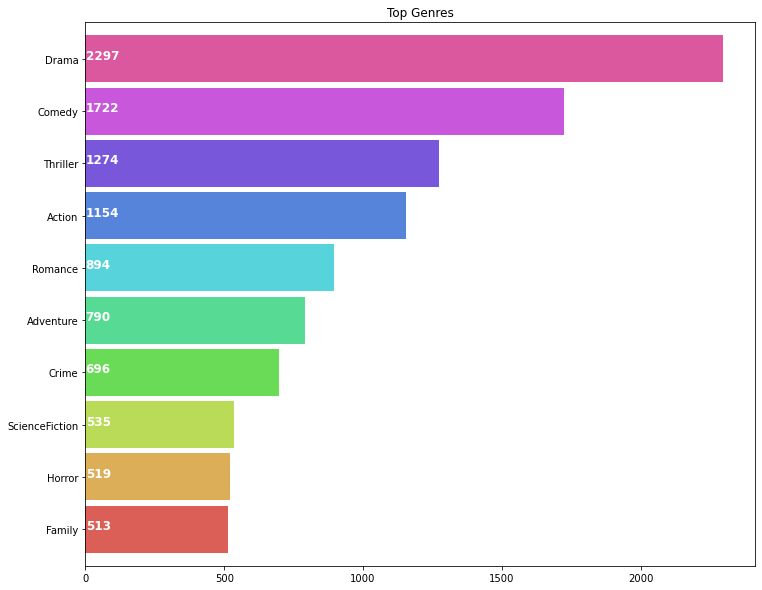

In [31]:
# Finding the top genres
plt.subplots(figsize=(12,10))
list1 = []
for i in movies_df['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

This plot depicts the occurence of genres in sequential order. We can see that the most popular genre is 'Drama' followed by 'Comedy'. 'Horror' and the 'Family' genre are shown to be less popular genres. 

In [32]:
movies_df['ratio'] = round((movies_df['vote_average']/movies_df['vote_count']) * 10000, 2)

In [33]:
movies_df.columns

Index(['id', 'title', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'vote_average', 'vote_count', 'ratio'],
      dtype='object')

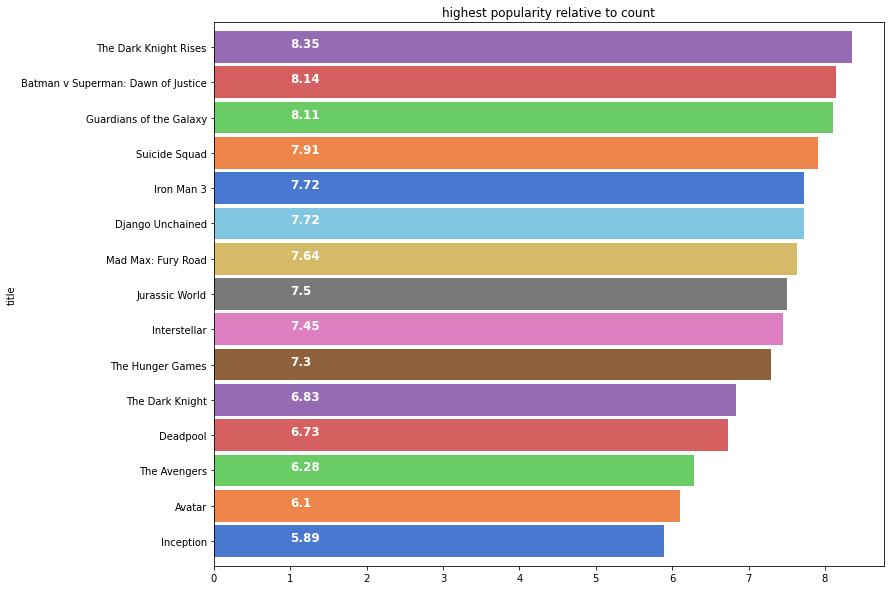

In [34]:
#Finding highest popularity relative to count

plt.subplots(figsize=(12,10))
title_idx=movies_df
title_idx.set_index('title',drop=True,inplace=True)
ax = title_idx['ratio'].sort_values(ascending=True)[1:16].plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(title_idx['ratio'].sort_values(ascending=True)[1:16].values): 
    ax.text(1, i, v,fontsize=12,color='white',weight='bold')
plt.title('highest popularity relative to count')
plt.show()

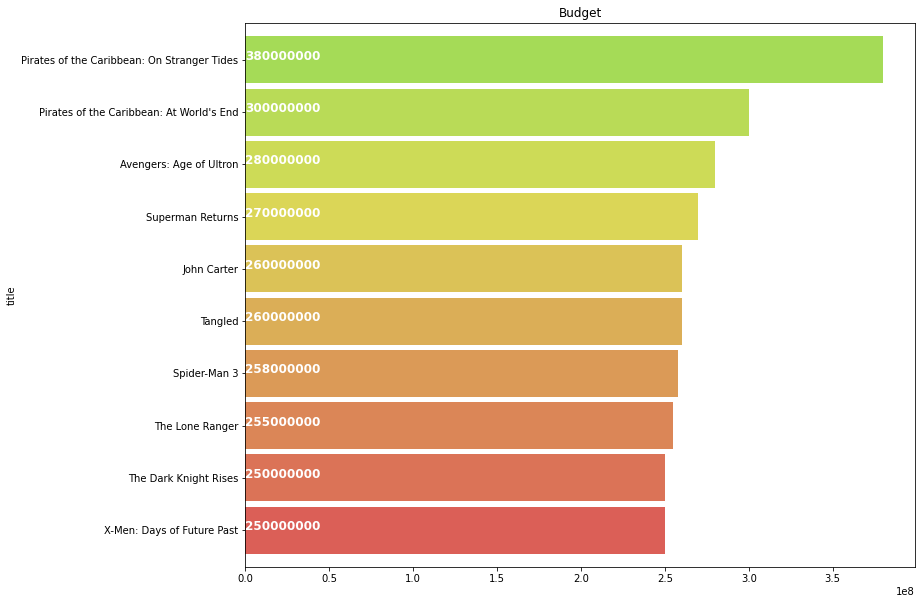

In [35]:
#Finding highest budget movies
plt.subplots(figsize=(12,10))
budget_title=movies_df
ax = budget_title['budget'].sort_values(ascending=True)[-10:].plot.barh(width=0.9,color=sns.color_palette('hls',40))
for i, v in enumerate(movies_df['budget'].sort_values(ascending=True)[-10:].values): 
    ax.text(1, i, v,fontsize=12,color='white',weight='bold')
plt.title('Budget')
plt.show()

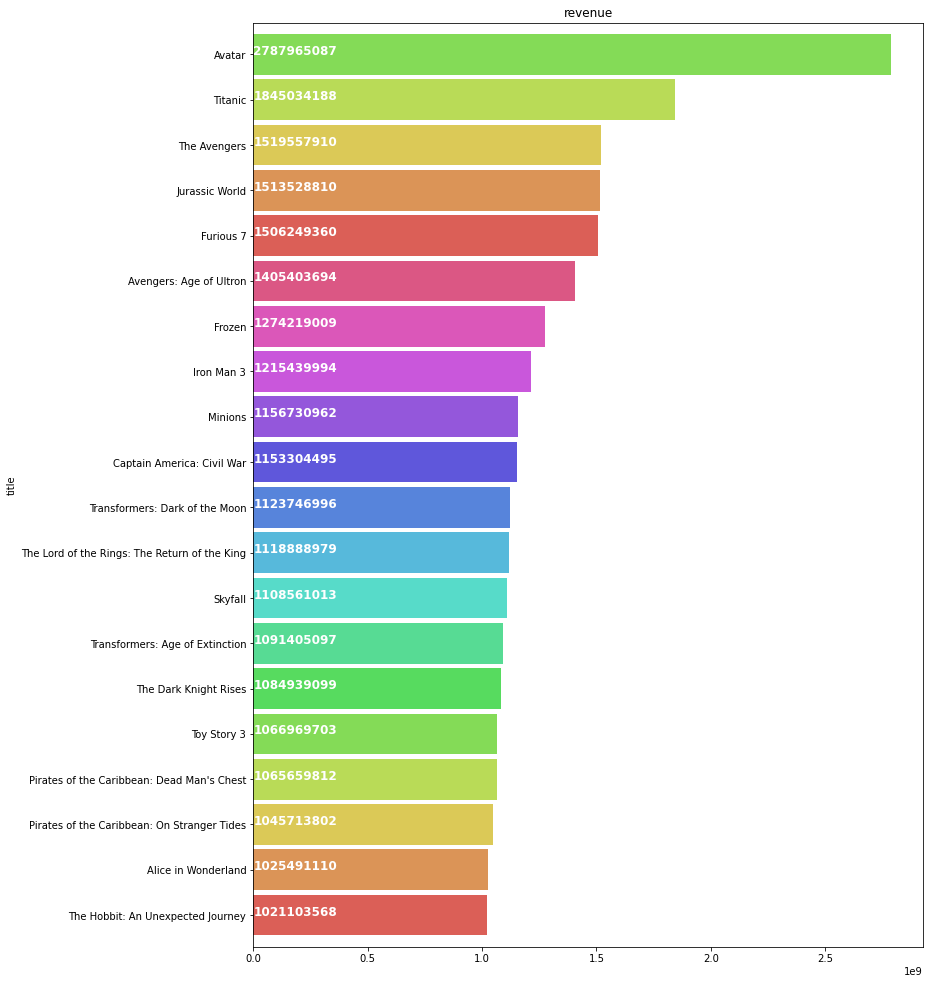

In [36]:
#Finding highest revenue movies
plt.subplots(figsize=(12,17))
budget_title=movies_df
ax = budget_title['revenue'].sort_values(ascending=True)[-20:].plot.barh(width=0.9,color=sns.color_palette('hls',15))
for i, v in enumerate(movies_df['revenue'].sort_values(ascending=True)[-20:].values): 
    ax.text(1, i, v,fontsize=12,color='white',weight='bold')
plt.title('revenue')
plt.show()

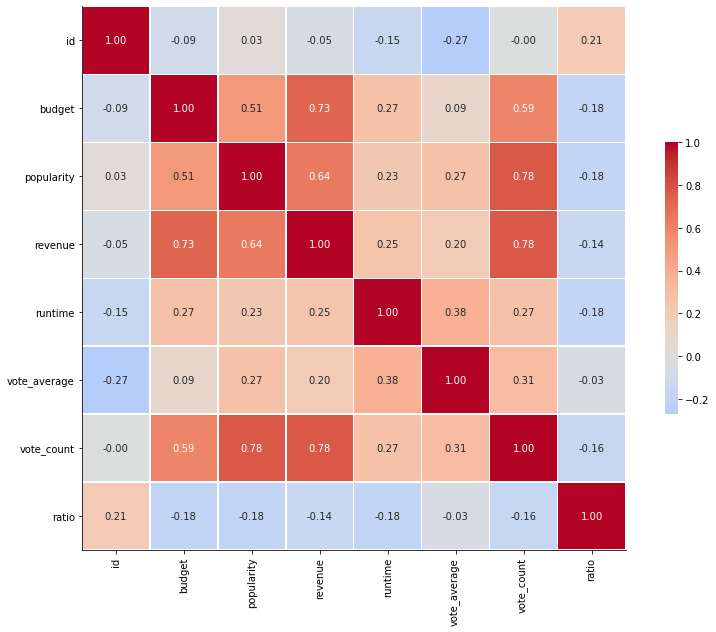

In [37]:
#Numeric columns corelation heatmap
import seaborn as sns
corr = movies_df.corr()
g = sns.heatmap(corr,  vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(14,10)

plt.show()

Converting into binary to calculate length between the data

In [38]:
#One hot encoding for genre
genreList = []
for i in movies_df['genres']:
    for genre in i:
        if genre not in genreList:
            genreList.append(genre)
genreList[:10]


def onehot(genre_list):
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

movies_df['genres_bin'] = movies_df['genres'].apply(lambda x: onehot(x))

In [41]:
#One hot encoding for Cast
castList = []
for i in movies_df['cast']:
    for main in i[:4]:
        if main not in castList:
            castList.append(main)
def onehotcast(genre_list):
    binaryList = []
    
    for genre in castList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList
movies_df['cast_bin'] = movies_df['cast'].apply(lambda x: onehotcast(x))

In [42]:
#One hot encoding for keywords
keywordList = []
for i in movies_df['keywords']:
    for main in i:
        if main not in keywordList:
            keywordList.append(main)
def onehotcast(genre_list):
    binaryList = []
    
    for genre in keywordList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList
movies_df['keywords_bin'] = movies_df['keywords'].apply(lambda x: onehotcast(x))
movies_df

,id,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,vote_average,vote_count,ratio,genres_bin,cast_bin,keywords_bin
title,,,,,,,,,,,,,,,,,,,,,
Avatar,19995,"[Sam Worthington, Zoe Saldana, Sigourney Wea...","[Stephen E. Rivkin, Rick Carter, Christopher...",237000000,"[Action, Adventure, Fantasy, ScienceFiction]",http://www.avatarmovie.com/,"[culture clash, future, space war, space co...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,6.10,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
Pirates of the Caribbean: At World's End,285,"[Johnny Depp, Orlando Bloom, Keira Knightley...","[Dariusz Wolski, Gore Verbinski, Jerry Bruck...",300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,"[ocean, drug abuse, exotic island, east ind...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",...,169.0,[English],Released,"At the end of the world, the adventure begins.",6.9,4500,15.33,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Spectre,206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux,...","[Thomas Newman, Sam Mendes, Anna Pinnock, J...",245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,"[spy, based on novel, secret agent, sequel,...",en,Spectre,A cryptic message from Bond’s past sends him o...,...,148.0,"[Français, English, Español, Italiano, Deu...",Released,A Plan No One Escapes,6.3,4466,14.11,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
The Dark Knight Rises,49026,"[Christian Bale, Michael Caine, Gary Oldman,...","[Hans Zimmer, Charles Roven, Christopher Nol...",250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,"[dc comics, crime fighter, terrorist, secre...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,...,165.0,[English],Released,The Legend Ends,7.6,9106,8.35,"[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
John Carter,49529,"[Taylor Kitsch, Lynn Collins, Samantha Morto...","[Andrew Stanton, Andrew Stanton, John Lasset...",260000000,"[Action, Adventure, ScienceFiction]",http://movies.disney.com/john-carter,"[based on novel, mars, medallion, space tra...",en,John Carter,"John Carter is a war-weary, former military ca...",...,132.0,[English],Released,"Lost in our world, found in another.",6.1,2124,28.72,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
El Mariachi,9367,"[Carlos Gallardo, Jaime de Hoyos, Peter Marq...","[Robert Rodriguez, Robert Rodriguez, Robert ...",220000,"[Action, Crime, Thriller]",NaN,"[united states–mexico barrier, legs, arms, ...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,...,81.0,[Español],Released,"He didn't come looking for trouble, but troubl...",6.6,238,277.31,"[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Newlyweds,72766,"[Edward Burns, Kerry Bishé, Marsha Dietlein,...","[Edward Burns, Edward Burns, Edward Burns, ...",9000,"[Comedy, Romance]",NaN,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,...,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,5.9,5,11800.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0,

In [45]:
#Calculate data similarity using cosine distance
from scipy import spatial

def Similarity(movieId1, movieId2):
    a = movies_df.iloc[movieId1]
    b = movies_df.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    genreDistance = spatial.distance.cosine(genresA, genresB)
    
    castA = a['cast_bin']
    castB = b['cast_bin']
    castDistance = spatial.distance.cosine(castA, castB)
    
    wordsA = a['keywords_bin']
    wordsB = b['keywords_bin']
    wordsDistance = spatial.distance.cosine(wordsA, wordsB)
    return genreDistance + castDistance + wordsDistance


In [46]:
Similarity(47,1)

2.3333333333333335

In [47]:
print(movies_df.iloc[47])

id                                                                  54138
cast                    [Chris Pine,  Zachary Quinto,  Zoe Saldana,  K...
crew                    [Michael Kaplan,  Ben Burtt,  Gene Roddenberry...
budget                                                          190000000
genres                                [Action, Adventure, ScienceFiction]
homepage                                                              NaN
keywords                [spacecraft,  friendship,  sequel,  futuristic...
original_language                                                      en
original_title                                    Star Trek Into Darkness
overview                When the crew of the Enterprise is called back...
popularity                                                         78.291
production_companies    [Paramount Pictures,  Skydance Productions,  B...
production_countries                           [United States of America]
release_date                          

In [48]:
print(movies_df.iloc[1])

id                                                                    285
cast                    [Johnny Depp,  Orlando Bloom,  Keira Knightley...
crew                    [Dariusz Wolski,  Gore Verbinski,  Jerry Bruck...
budget                                                          300000000
genres                                       [Adventure, Fantasy, Action]
homepage                     http://disney.go.com/disneypictures/pirates/
keywords                [ocean,  drug abuse,  exotic island,  east ind...
original_language                                                      en
original_title                   Pirates of the Caribbean: At World's End
overview                Captain Barbossa, long believed to be dead, ha...
popularity                                                        139.083
production_companies    [Walt Disney Pictures,  Jerry Bruckheimer Film...
production_countries                           [United States of America]
release_date                          

In [49]:
movies_df=movies_df.reset_index()
movies_df

,title,id,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,runtime,spoken_languages,status,tagline,vote_average,vote_count,ratio,genres_bin,cast_bin,keywords_bin
0,Avatar,19995,"[Sam Worthington, Zoe Saldana, Sigourney Wea...","[Stephen E. Rivkin, Rick Carter, Christopher...",237000000,"[Action, Adventure, Fantasy, ScienceFiction]",http://www.avatarmovie.com/,"[culture clash, future, space war, space co...",en,Avatar,...,162.0,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,6.10,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Pirates of the Caribbean: At World's End,285,"[Johnny Depp, Orlando Bloom, Keira Knightley...","[Dariusz Wolski, Gore Verbinski, Jerry Bruck...",300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,"[ocean, drug abuse, exotic island, east ind...",en,Pirates of the Caribbean: At World's End,...,169.0,[English],Released,"At the end of the world, the adventure begins.",6.9,4500,15.33,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Spectre,206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux,...","[Thomas Newman, Sam Mendes, Anna Pinnock, J...",245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,"[spy, based on novel, secret agent, sequel,...",en,Spectre,...,148.0,"[Français, English, Español, Italiano, Deu...",Released,A Plan No One Escapes,6.3,4466,14.11,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,The Dark Knight Rises,49026,"[Christian Bale, Michael Caine, Gary Oldman,...","[Hans Zimmer, Charles Roven, Christopher Nol...",250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,"[dc comics, crime fighter, terrorist, secre...",en,The Dark Knight Rises,...,165.0,[English],Released,The Legend Ends,7.6,9106,8.35,"[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,John Carter,49529,"[Taylor Kitsch, Lynn Collins, Samantha Morto...","[Andrew Stanton, Andrew Stanton, John Lasset...",260000000,"[Action, Adventure, ScienceFiction]",http://movies.disney.com/john-carter,"[based on novel, mars, medallion, space tra...",en,John Carter,...,132.0,[English],Released,"Lost in our world, found in another.",6.1,2124,28.72,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,El Mariachi,9367,"[Carlos Gallardo, Jaime de Hoyos, Peter Marq...","[Robert Rodriguez, Robert Rodriguez, Robert ...",220000,"[Action, Crime, Thriller]",NaN,"[united states–mexico barrier, legs, arms, ...",es,El Mariachi,...,81.0,[Español],Released,"He didn't come looking for trouble, but troubl...",6.6,238,277.31,"[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4799,Newlyweds,72766,"[Edward Burns, Kerry Bishé, Marsha Dietlein,...","[Edward Burns, Edward Burns, Edward Burns, ...",9000,"[Comedy, Romance]",NaN,[],en,Newlyweds,...,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,5.9,5,11800.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4800,"Signed, Sealed, Delivered",231617,"[Eric Mabius, Kristin Booth, Crystal Lowe, ...","[Carla Hetland, Harvey Kahn, Adam Sliwinski,...",0,"[Comedy, Drama, Romance, TVMovie]",http://www.hallmarkchannel.com/signedsealeddel...,"[date, lov

In [50]:
# KNN
import operator

def predict_score():
    name = input('Enter a movie title: ')
    new_movie_name = movies_df[movies_df['title'].str.lower().str.contains(name.lower())].index[0]
    new_movie_id= movies_df[movies_df['title'].str.lower().str.contains(name.lower())].iloc[0].to_frame().T
    print('Selected Movie: ',new_movie_id.title.get(key = new_movie_name) )
    def getNeighbors(baseMovie, K):
        distances = []
    
        for index, movie in enumerate(movies_df['id']):
            if movie != int(new_movie_id['id']):

                dist = Similarity(int(new_movie_id.index.values),index)
                distances.append((index, dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors
    
    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_movie_id, K)
    print('\nRecommended Movies: \n')
    for neighbor in neighbors:
        avgRating = avgRating+(movies_df.iloc[neighbor[0]]['vote_average'])
        print( str(movies_df.iloc[neighbor[0]][0])+" | Genres: "+str(movies_df.iloc[neighbor[0]]['genres']).strip('[]').replace(' ','')+" | Rating: "+str(movies_df.iloc[neighbor[0]]['vote_average']))
    
    print('\n')
    avgRating = avgRating/K
    print('The predicted rating for %s is: %f' %(new_movie_id['title'].values[0],avgRating))
    print('The actual rating for %s is %f' %(new_movie_id['title'].values[0],new_movie_id['vote_average']))

In [51]:
predict_score()

Enter a movie title: tangled
Selected Movie:  Tangled

Recommended Movies: 

Finding Nemo | Genres: 'Animation','Family' | Rating: 7.6
Winnie the Pooh | Genres: 'Animation','Family' | Rating: 6.8
Pinocchio | Genres: 'Animation','Family' | Rating: 6.9
Anastasia | Genres: 'Animation','Family' | Rating: 7.4
Ponyo | Genres: 'Animation','Family' | Rating: 7.5
Monsters University | Genres: 'Animation','Family' | Rating: 7.0
Coraline | Genres: 'Animation','Family' | Rating: 7.3
Lilo & Stitch | Genres: 'Animation','Family' | Rating: 7.1
Dinosaur | Genres: 'Animation','Family' | Rating: 6.2
Madagascar: Escape 2 Africa | Genres: 'Family','Animation' | Rating: 6.2


The predicted rating for Tangled is: 7.000000
The actual rating for Tangled is 7.400000
